In [1]:
#############################################################################
# IMPORTS AND SETUP
#############################################################################
# Set random seed for reproducibility
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True  # Makes training more deterministic
torch.backends.cudnn.benchmark = False     # Can speed up training when input sizes don't change

# Standard imports
import pandas as pd
import numpy as np
import polars as pl
from datetime import datetime, timedelta
import time
import os

from tqdm.auto import tqdm  # Progress bar


# Check and set up GPU (support MPS on Mac)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Print extra info
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
elif device.type == "mps":
    print("Using Apple Silicon GPU via Metal Performance Shaders (MPS)")


# ##### 强制使用CPU
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# device = torch.device("cpu")
# # Force JAX to use the CPU backend only (avoids CUDA OOM in JAX)
# os.environ['JAX_PLATFORMS'] = 'cpu'

Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)


/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd

# PyEPO imports
from pyepo.data.dataset import optDataset

# Gurobi
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

# Pyomo
from pyomo import environ as pe
from pyepo.model.omo import optOmoModel # 记得要把 omo 文件夹里的 __init__.py 文件也修改了
from pyepo import EPO

# COPTPy
from coptpy import Envr, COPT
from pyepo.model.copt import optCoptModel

# MPAX
from pyepo.model.mpax import optMpaxModel

# Training and Testing


## 随机生成横截面xy数据

In [3]:
#############################################################################
# DATA PREPARATION
#############################################################################
print("Generating random data...")

# Setting parameters
k = 5  # number of x features
m = 3  # number of y features
N_symbol = 100  # Number of symbols to generate

# Generate symbols: s1, s2, ..., s100
symbols = [f's{i}' for i in range(1, N_symbol + 1)]

# Generate time range: minutes from 2025-04-01 to 2025-04-01 01:59
start_time = datetime(2025, 4, 1)
end_time = datetime(2025, 4, 1, 1, 59)
minutes_diff = int((end_time - start_time).total_seconds() / 60) + 1
time_range = [start_time + timedelta(minutes=i) for i in range(minutes_diff)]

# Create empty dataframe with desired columns
columns = ['time', 'symbol'] + [f'x{i+1}' for i in range(k)] + [f'y{i+1}' for i in range(m)]
data = []

# Generate random data
for time in time_range:
    for symbol in symbols:
        # Generate white noise for each x and y
        x_values = np.random.normal(0, 1, k)
        y_values = np.random.normal(0, 1, m)
        
        # Combine all values into a row
        row = [time, symbol] + list(x_values) + list(y_values)
        data.append(row)

# Create DataFrame
# df = pd.DataFrame(data, columns=columns)
df = pl.DataFrame(data, schema=[(col, pl.Datetime if col == 'time' else pl.Utf8 if col == 'symbol' else pl.Float64) 
                                     for col in columns])

# Optional: Save to CSV
# df.to_csv("random_data.csv", index=False)

Generating random data...


In [4]:
# 存储df为.parquet文件
df.write_parquet("data_sample.parquet")

In [5]:
y_col = 'y1'  # Specify the y column to be used for costs

# 1. Find all x columns
x_cols = [c for c in df.columns if c.startswith("x")]

# 2. Pivot costs matrix: shape (T, N)
cost_pivot = (
    df
    .pivot(
        values=y_col,
        index="time",
        columns="symbol",
        aggregate_function="first",   # Ensure only one value per (time, symbol) pair
    )
    .sort("time")                     # Sort by time
    .fill_null(0)                     # Fill missing values with 0
)
# Extract time and symbol information
unique_times = cost_pivot["time"].to_list()
unique_symbols = cost_pivot.columns[1:]    # All columns except 'time' are symbols

# Convert to numpy for PyTorch compatibility
costs = cost_pivot.select(unique_symbols).to_numpy()

# 3. Pivot each feature (x) and stack into a 3D tensor (T, N, k)
feature_mats = []
for x in x_cols:
    mat = (
        df
        .pivot(
            values=x,
            index="time",
            columns="symbol",
            aggregate_function="first",
        )
        .sort("time")
        .fill_null(0)
        .select(unique_symbols)
        .to_numpy()
    )
    feature_mats.append(mat)
# Stack along the third dimension to create (T, N, k) tensor
features = np.stack(feature_mats, axis=2)  # (T, N, k)

print(f"Data shape: features {features.shape}, costs {costs.shape}")

#############################################################################
# TRAIN-TEST SPLIT
#############################################################################
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(features, costs, test_size=70, random_state=42)
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}")

Data shape: features (120, 100, 5), costs (120, 100)
Training set: (50, 100, 5), Test set: (70, 100, 5)


In [6]:
#############################################################################
# OPTIMIZATION PROBLEM PARAMETERS
#############################################################################
# Market neutral optimization model parameters from opt_time_compare.py
N = features.shape[1]  # Number of assets, updated from data
A = np.ones((1, N))
b = np.array([1.0])
l = np.zeros(N)
u = np.zeros(N) + 1e6

# Generate random positive definite covariance matrix
M = np.random.randn(N, N)
cov_matrix = M.T @ M + np.eye(N) * 1e-3

# Risk and constraint parameters
risk_f     = np.random.randn(N)
risk_abs   = 1.5
single_abs = 0.1
l1_abs     = 1.0
sigma_abs  = 2.5


#############################################################################
# MARKET NEUTRAL OPTIMIZATION MODEL
#############################################################################
class MarketNeutralGrbModel(optGrbModel):
    def __init__(
        self,
        N,
        A,
        b,
        l,
        u,
        minimize=False,
        risk_f=None,
        risk_abs=None,
        single_abs=None,
        l1_abs=None,
        cov_matrix=None,
        sigma_abs=None
    ):
        # 保存所有参数
        self.N = N
        self.A = A
        self.b = b
        self.l = l
        self.u = u
        self.minimize = minimize
        self.risk_f = risk_f
        self.risk_abs = risk_abs
        self.single_abs = single_abs
        self.l1_abs = l1_abs
        self.cov_matrix = cov_matrix
        self.sigma_abs = sigma_abs

        super().__init__()

    def _getModel(self):
        # 新建 Gurobi 模型
        m = gp.Model()

        # 添加原始变量 x[i]
        x = m.addVars(
            self.N,
            lb={i: float(self.l[i]) for i in range(self.N)},
            ub={i: float(self.u[i]) for i in range(self.N)},
            name="x"
        )

        # 用于 L1 约束的辅助变量 t[i]
        t = m.addVars(self.N, lb=0.0, name="t")

        # 设置优化方向
        m.modelSense = GRB.MINIMIZE if self.minimize else GRB.MAXIMIZE

        # ——— 1) 市场中性约束 sum A[0,i] * x[i] == b[0]
        m.addConstr(
            gp.quicksum(self.A[0, i] * x[i] for i in range(self.N)) == float(self.b[0]),
            name="eq_sum"
        )

        # ——— 2) 风险约束 |risk_f' x| <= risk_abs
        expr_r = gp.quicksum(self.risk_f[i] * x[i] for i in range(self.N))
        m.addConstr(expr_r <= float(self.risk_abs), name="risk_ub")
        m.addConstr(expr_r >= -float(self.risk_abs), name="risk_lb")

        # ——— 3) 单项绝对值约束 |x_i| <= single_abs
        for i in range(self.N):
            m.addConstr(x[i] <=  float(self.single_abs),  name=f"single_ub_{i}")
            m.addConstr(x[i] >= -float(self.single_abs), name=f"single_lb_{i}")

        # ——— 4) L1 约束 ∑|x_i| <= l1_abs
        #   实现方式： t[i] >=  x[i], t[i] >= -x[i], 然后 ∑ t[i] <= l1_abs
        for i in range(self.N):
            m.addConstr(t[i] >=  x[i], name=f"t_pos_{i}")
            m.addConstr(t[i] >= -x[i], name=f"t_neg_{i}")
        m.addConstr(t.sum() <= float(self.l1_abs), name="l1_norm")

        # ——— 5) 二次型约束 x' * cov_matrix * x <= sigma_abs
        #     向量化写法： x_vec @ cov_matrix @ x_vec
        x_vec = np.array([x[i] for i in range(self.N)])
        expr_q = x_vec @ self.cov_matrix @ x_vec
        m.addQConstr(expr_q <= float(self.sigma_abs), name="sigma_qc")

        return m, x
    
# Create an instance of the market neutral model for testing
market_neutral_model = MarketNeutralGrbModel(
    N, A, b, l, u, minimize=False,
    risk_f=risk_f, risk_abs=risk_abs,
    single_abs=single_abs, l1_abs=l1_abs,
    cov_matrix=cov_matrix, sigma_abs=sigma_abs
)

# Optionally, you can test the model here
# c_test = np.random.rand(N)
# market_neutral_model.setObj(c_test)
# sol = market_neutral_model.solve()
# print(f"Test solution objective value: {market_neutral_model.getObjVal()}")

# Create datasets
dataset_train = optDataset(market_neutral_model, x_train, c_train)
dataset_test = optDataset(market_neutral_model, x_test, c_test)

Restricted license - for non-production use only - expires 2026-11-23
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 108.03it/s]

Optimizing for optDataset...



100%|██████████| 70/70 [00:00<00:00, 113.55it/s]


In [7]:
#############################################################################
# DATA LOADERS WITH PREFETCHING
#############################################################################
from torch.utils.data import DataLoader
# Find optimal batch size based on GPU memory
# Start with a reasonable default
batch_size = 8  

generator = torch.Generator()
generator.manual_seed(42)

# Configure data loaders with prefetching
loader_train = DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    shuffle=True,
    generator=generator # 固定data loader的生成器 - 用于对比MLP & MLP_Forloop
    # pin_memory=True,  # Speed up host to GPU transfers
    # num_workers=2,    # Prefetch in parallel
    # persistent_workers=True  # Keep workers alive between epochs
)

loader_test = DataLoader(
    dataset_test, 
    batch_size=batch_size, 
    shuffle=False,
    # pin_memory=True,
    # num_workers=1
)

# move loader to device for logging regret
def device_loader(loader, device):
    for batch in loader:
        x, c, w, z = batch
        yield x.to(device), c.to(device), w.to(device), z.to(device)

## 预测模型

In [14]:
#############################################################################
# PREDICTION MODEL
#############################################################################
from torch import nn
import torch
# torch.manual_seed(42)  


class EnhancedLinearRegression(nn.Module):
    """
    Enhanced linear regression model with batch normalization
    for improved training stability
    """
    def __init__(self, k: int, dropout_rate=0.0):
        super().__init__()
        # Feature normalization
        self.batch_norm = nn.BatchNorm1d(k)
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        # Linear layer - maps k features to 1 output
        self.linear = nn.Linear(in_features=k, out_features=1)
        
        # Initialize weights properly
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        # x: (batch_size, N, k) -> reshape for batch norm
        batch_size, N, k = x.shape
        x_reshaped = x.reshape(-1, k)  # (batch_size*N, k)
        
        # Apply batch normalization
        x_normalized = self.batch_norm(x_reshaped)
        
        # Apply dropout if enabled
        if self.dropout is not None:
            x_normalized = self.dropout(x_normalized)
            
        # Apply linear layer
        output = self.linear(x_normalized)  # (batch_size*N, 1)
        
        # Reshape back to original dimensions
        output = output.reshape(batch_size, N)  # (batch_size, N)
        
        return output

# Initialize model and move to GPU
reg = EnhancedLinearRegression(k=k, dropout_rate=0.1).to(device)

# Print model summary
print("Model architecture:")
for name, param in reg.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Value: {param.data} | Grad: {param.grad}")
    
    
print(f"Total parameters: {sum(p.numel() for p in reg.parameters())}")


Model architecture:
batch_norm.weight    | Shape: torch.Size([5]) | Parameters: 5 | require_Grad: True
Value: tensor([1., 1., 1., 1., 1.], device='mps:0') | Grad: None
batch_norm.bias      | Shape: torch.Size([5]) | Parameters: 5 | require_Grad: True
Value: tensor([0., 0., 0., 0., 0.], device='mps:0') | Grad: None
linear.weight        | Shape: torch.Size([1, 5]) | Parameters: 5 | require_Grad: True
Value: tensor([[-0.1044, -0.4445, -0.5228,  0.7091,  0.3619]], device='mps:0') | Grad: None
linear.bias          | Shape: torch.Size([1]) | Parameters: 1 | require_Grad: True
Value: tensor([0.], device='mps:0') | Grad: None
Total parameters: 16


In [18]:
class TwoLayerMLP(nn.Module):
    """
    Two-layer MLP model with batch normalization and optional dropout
    """
    def __init__(self, k: int, hidden_dim: int=32, dropout_rate=0.0):
        super().__init__()
        # Feature normalization
        self.batch_norm = nn.BatchNorm1d(k)
        
        # First layer: k -> hidden_dim
        self.fc1 = nn.Linear(k, hidden_dim)
        
        # Second layer: hidden_dim -> 1
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Activation function
        self.activation = nn.ReLU()
        
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
        # Initialize weights properly
        nn.init.xavier_normal(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        # x: (batch_size, N, k) -> reshape for batch norm
        batch_size, N, k = x.shape
        x_reshaped = x.reshape(-1, k) # (batch_size*N, k)
        
        # Apply batch normalization
        x_normalized = self.batch_norm(x_reshaped)
        
        # First linear layer + activation
        x_hidden = self.fc1(x_normalized)
        x_hidden = self.activation(x_hidden)
        
        # Optional dropout 
        if self.dropout is not None:
            x_hidden = self.dropout(x_hidden)
        
        # Second linear layer (output)
        output = self.fc2(x_hidden) # (batch_size*N, 1)
        
        # Reshape back to (batch_size, N)
        output = output.reshape(batch_size, N)
        
        return output
    

# Initialize model and move to gpu
mlp = TwoLayerMLP(k=k, hidden_dim=32, dropout_rate=0.0).to(device)

# Print model summary
print("Model architecture:")
for name, param in mlp.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")

Model architecture:
batch_norm.weight    | Shape: torch.Size([5]) | Parameters: 5 | require_Grad: True
Mean Value: 1.0 | Grad: None
batch_norm.bias      | Shape: torch.Size([5]) | Parameters: 5 | require_Grad: True
Mean Value: 0.0 | Grad: None
fc1.weight           | Shape: torch.Size([32, 5]) | Parameters: 160 | require_Grad: True
Mean Value: 0.010149108245968819 | Grad: None
fc1.bias             | Shape: torch.Size([32]) | Parameters: 32 | require_Grad: True
Mean Value: 0.0 | Grad: None
fc2.weight           | Shape: torch.Size([1, 32]) | Parameters: 32 | require_Grad: True
Mean Value: 0.013554740697145462 | Grad: None
fc2.bias             | Shape: torch.Size([1]) | Parameters: 1 | require_Grad: True
Mean Value: 0.0 | Grad: None


/var/folders/gz/20943px51778bvz4gc4xcdj00000gn/T/ipykernel_1446/2483201312.py:23: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.fc1.weight)
/var/folders/gz/20943px51778bvz4gc4xcdj00000gn/T/ipykernel_1446/2483201312.py:25: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.fc2.weight)


In [19]:
class TwoLayerMLPForloop(TwoLayerMLP):
    """
    Same structure as TwoLayerMLP, but manually apply forward pass one by one
    """
    def forward(self, x):
        batch_size, N, k = x.shape
        outputs = []
        # (1) BatchNorm
        x_norm = self.batch_norm(x.reshape(-1, k)).reshape(batch_size, N, k)

        for t in range(batch_size):
            for n in range(N):
                x_single = x_norm[t, n, :]  # shape (k,)

                # (2) First linear layer + activation
                x_hidden = self.activation(self.fc1(x_single))  # (1, hidden_dim)
            
                # (3) Optional dropout
                if self.dropout is not None:
                    x_hidden = self.dropout(x_hidden)

                # (4) Second linear layer (output)
                x_out = self.fc2(x_hidden)  # (1, 1)

                outputs.append(x_out.squeeze())  # squeeze to scalar
        
        # Collect all outputs
        outputs = torch.stack(outputs)  # shape (batch_size * N,)
        outputs = outputs.view(batch_size, N)  # reshape back
        return outputs
    
# Initialize model and move to gpu
mlp_fl = TwoLayerMLPForloop(k=k, hidden_dim=32, dropout_rate=0.0).to(device)
mlp_fl.load_state_dict(mlp.state_dict()) # 保证两个版本下参数初始化一致

# Print model summary
print("Model architecture:")
for name, param in mlp_fl.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")

Model architecture:
batch_norm.weight    | Shape: torch.Size([5]) | Parameters: 5 | require_Grad: True
Mean Value: 1.0 | Grad: None
batch_norm.bias      | Shape: torch.Size([5]) | Parameters: 5 | require_Grad: True
Mean Value: 0.0 | Grad: None
fc1.weight           | Shape: torch.Size([32, 5]) | Parameters: 160 | require_Grad: True
Mean Value: 0.010149108245968819 | Grad: None
fc1.bias             | Shape: torch.Size([32]) | Parameters: 32 | require_Grad: True
Mean Value: 0.0 | Grad: None
fc2.weight           | Shape: torch.Size([1, 32]) | Parameters: 32 | require_Grad: True
Mean Value: 0.013554740697145462 | Grad: None
fc2.bias             | Shape: torch.Size([1]) | Parameters: 1 | require_Grad: True
Mean Value: 0.0 | Grad: None


/var/folders/gz/20943px51778bvz4gc4xcdj00000gn/T/ipykernel_1446/2483201312.py:23: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.fc1.weight)
/var/folders/gz/20943px51778bvz4gc4xcdj00000gn/T/ipykernel_1446/2483201312.py:25: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.fc2.weight)


## 训练函数

In [20]:
#############################################################################
# TRAINING WITH MIXED PRECISION
#############################################################################
import time
from torch.amp import GradScaler, autocast
import pyepo

def trainModel(model, loss_func, method_name, num_epochs=5, lr=1e-3):
    """
    Enhanced training function with:
    - Mixed precision for faster GPU training
    - Learning rate scheduling
    - Progress bars
    - Detailed logging
    - Memory-efficient tensor handling
    """
    # Set up optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1
    )
    
    # Enable mixed precision training
    scaler = GradScaler(enabled=(device.type in ["cuda", "mps"]))

    # Set model to training mode
    model.train()
    
    # Initialize logs
    loss_log = []
    # evaluate loss on whole test data
    loss_log_regret = [pyepo.metric.regret(model, market_neutral_model, device_loader(loader_test, device))]
    print(f"Initial regret: {loss_log_regret[0]*100:.4f}%")
    
    # Initialize elapsed time tracking
    training_start = time.time()
    total_elapsed = 0
    
    # Verbosity control - set to false for production
    debug_mode = False
    log_interval = 10  # Log every N batches
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_start = time.time()
        
        # Progress bar for this epoch
        progress_bar = tqdm(loader_train, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, data in enumerate(progress_bar):
            x, c, w, z = data
            
            # Move data to GPU (once, not in every batch)
            x, c, w, z = x.to(device), c.to(device), w.to(device), z.to(device)
            
            # Record batch start time for accurate timing
            batch_start = time.time()
            
            # Clear gradients for each batch
            optimizer.zero_grad()
            
            # Use mixed precision where appropriate
            with autocast(device_type=device.type, enabled=(device.type in ["cuda", "mps"])):
                # Forward pass
                cp = model(x)
                
                # Compute loss based on method
                if method_name == "spo+":
                    loss = loss_func(cp, c, w, z)
                elif method_name in ["ptb", "pfy", "imle", "aimle", "nce", "cmap"]:
                    loss = loss_func(cp, w)
                elif method_name in ["dbb", "nid"]:
                    loss = loss_func(cp, c, z)
                elif method_name in ["pg", "ltr"]:
                    loss = loss_func(cp, c)
            
            # Backward pass with mixed precision handling
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            
            # Track batch elapsed time
            batch_elapsed = time.time() - batch_start
            total_elapsed += batch_elapsed
            
            # Update loss tracking
            current_loss = loss.item()
            epoch_loss += current_loss
            loss_log.append(current_loss)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{current_loss:.4f}", 
                'batch time': f"{batch_elapsed:.4f}s"
            })
            
            # Debug logging (limited to avoid overwhelming output)
            if debug_mode and i % log_interval == 0:
                print(f"\n[Debug] Batch {i} stats:")
                print(f"Loss: {current_loss:.6f}")
                print(f"Pred shape: {cp.shape}, values: {cp[0,:5].detach().cpu().numpy()}")
                
                # Monitor memory usage
                if device.type == 'cuda':
                    mem_allocated = torch.cuda.memory_allocated() / 1024**2
                    mem_reserved = torch.cuda.memory_reserved() / 1024**2
                    print(f"GPU Memory: {mem_allocated:.1f}MB allocated, {mem_reserved:.1f}MB reserved")
        
        # Compute regret on test set after each epoch
        with torch.no_grad():
            model.eval()  # Set model to evaluation mode
            regret = pyepo.metric.regret(model, market_neutral_model, device_loader(loader_test, device))
            model.train()  # Set back to training mode
            loss_log_regret.append(regret)
        
        # Update learning rate scheduler
        scheduler.step(epoch_loss)
        
        # End of epoch reporting
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}: Loss={epoch_loss/len(loader_train):.6f}, "
              f"Regret={regret*100:.4f}%, Time={epoch_time:.2f}s")
    
    # Report total training time
    total_training_time = time.time() - training_start
    print(f"Total training time: {total_training_time:.2f}s, "
          f"Effective computation time: {total_elapsed:.2f}s")
    
    return loss_log, loss_log_regret

#############################################################################
# TRAINING EXECUTION 
#############################################################################
print("\nInitializing SPO+ loss function...")
spop = pyepo.func.SPOPlus(market_neutral_model)


Initializing SPO+ loss function...
Num of cores: 1


In [21]:
print("\nStarting model training...")
loss_log, loss_log_regret = trainModel(
    mlp, 
    loss_func=spop, 
    method_name="spo+",
    num_epochs=5,  # Increased for better convergence
    lr=1e-3        # Adjusted learning rate
)

loss_log_fl, loss_log_regret_fl = trainModel(
    mlp_fl, 
    loss_func=spop, 
    method_name="spo+",
    num_epochs=5,  # Increased for better convergence
    lr=1e-3        # Adjusted learning rate
)


Starting model training...


/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Initial regret: 99.6509%


Epoch 1/5: 100%|██████████| 7/7 [00:00<00:00, 10.55it/s, loss=3.3958, batch time=0.0321s]


Epoch 1: Loss=3.180035, Regret=99.6707%, Time=1.38s


Epoch 2/5: 100%|██████████| 7/7 [00:00<00:00, 11.78it/s, loss=2.7424, batch time=0.0303s]


Epoch 2: Loss=3.014988, Regret=99.9285%, Time=1.31s


Epoch 3/5: 100%|██████████| 7/7 [00:00<00:00, 12.11it/s, loss=3.1200, batch time=0.0288s]


Epoch 3: Loss=2.974905, Regret=100.0568%, Time=1.29s


Epoch 4/5: 100%|██████████| 7/7 [00:00<00:00, 11.29it/s, loss=3.0307, batch time=0.0290s]


Epoch 4: Loss=2.911039, Regret=99.9533%, Time=1.37s


Epoch 5/5: 100%|██████████| 7/7 [00:00<00:00, 11.35it/s, loss=2.7633, batch time=0.0302s]


Epoch 5: Loss=2.840235, Regret=99.8538%, Time=1.33s
Total training time: 6.69s, Effective computation time: 2.95s
Initial regret: 99.6511%


Epoch 1/5: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, loss=3.3122, batch time=0.2764s]


Epoch 1: Loss=3.169526, Regret=99.6888%, Time=9.66s


Epoch 2/5: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s, loss=2.8746, batch time=0.2788s]


Epoch 2: Loss=3.023909, Regret=99.8877%, Time=9.50s


Epoch 3/5: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, loss=3.1885, batch time=0.2877s]


Epoch 3: Loss=2.981236, Regret=100.0980%, Time=9.59s


Epoch 4/5: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, loss=2.7150, batch time=0.2855s]


Epoch 4: Loss=2.872137, Regret=99.9955%, Time=9.57s


Epoch 5/5: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, loss=2.9831, batch time=0.2788s]


Epoch 5: Loss=2.859857, Regret=99.8124%, Time=9.48s
Total training time: 47.81s, Effective computation time: 34.30s


## 可视化 loss 


Visualizing learning curves...


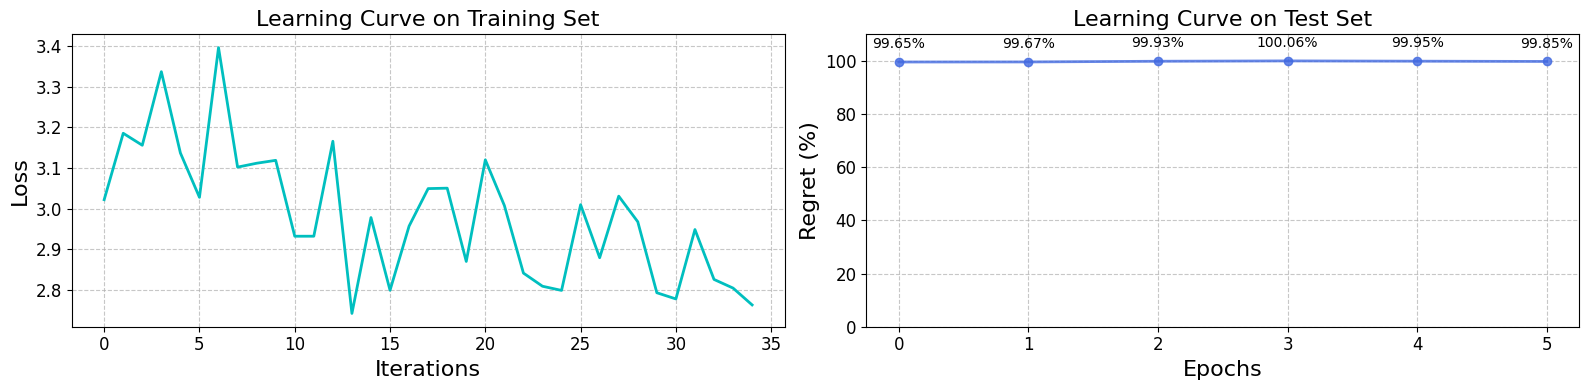

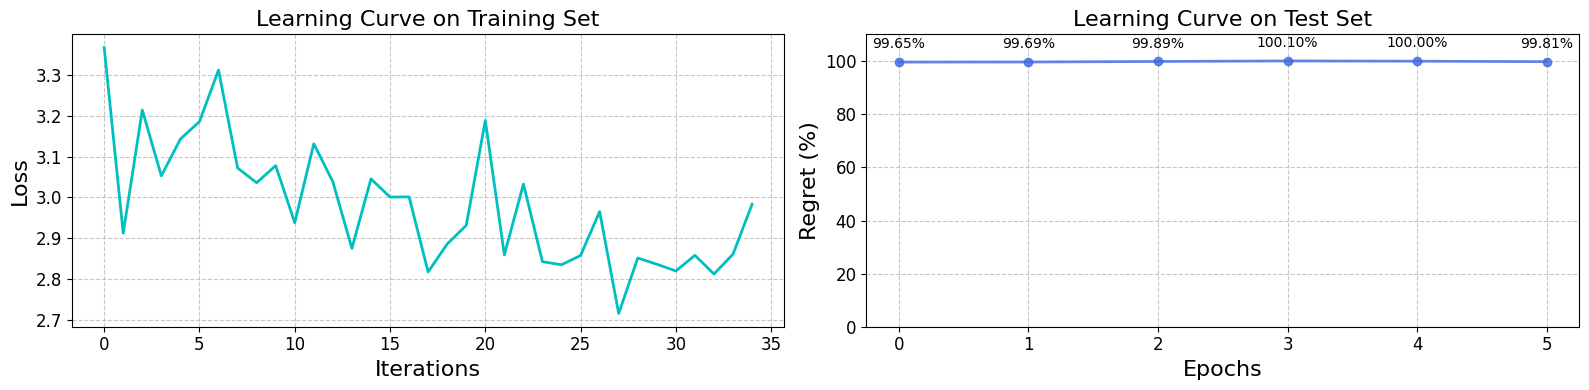

In [22]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)
visLearningCurve(loss_log_fl, loss_log_regret_fl)